In [37]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score


Preprocessing

In [39]:
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Canny edge detection
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    edges = cv2.Canny(image, 100, 200)
    img = Image.fromarray(edges)
    
    return img

# Apply preprocessing and save to new directory
input_dir = 'images'
output_dir = 'processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            preprocessed_img.save(os.path.join(output_category_path, image_name))

Train/Test Split

In [27]:
train_dir = 'images_train_test_val/train'
validation_dir = 'images_train_test_val/validation'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.


Base Model Creation

In [28]:
def create_model(optimizer='adam', init_mode='uniform'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init_mode))
    model.add(Dropout(0.5))
    model.add(Dense(21, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Model Creation

In [29]:
model = create_model()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-10 09:35:19.109330: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-10 09:35:19.109528: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-10 09:35:19.109538: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-10 09:35:19.110041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 09:35:19.110702: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

Epoch 1/10


2024-07-10 09:35:21.884803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


230/230 ━━━━━━━━━━━━━━━━━━━━ 187s 771ms/step - accuracy: 0.0601 - loss: 3.0668 - val_accuracy: 0.1138 - val_loss: 2.8197
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 159s 675ms/step - accuracy: 0.1239 - loss: 2.7853 - val_accuracy: 0.1871 - val_loss: 2.6116
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.1828 - loss: 2.6145 - val_accuracy: 0.2033 - val_loss: 2.5385
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.2355 - loss: 2.4266 - val_accuracy: 0.2705 - val_loss: 2.2912
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.2957 - loss: 2.2747 - val_accuracy: 0.2867 - val_loss: 2.2752
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.3175 - loss: 2.1504 - val_accuracy: 0.3276 - val_loss: 2.1047
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 141s 599ms/step - accuracy: 0.3656 - loss: 2.0404 - val_accuracy: 0.3471 - val_loss: 2.0281
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 149s 636ms/step - accuracy: 0.3729 - loss: 1.9720 - val_acc

In [30]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(validation_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}')

230/230 ━━━━━━━━━━━━━━━━━━━━ 74s 322ms/step - accuracy: 0.5129 - loss: 1.5842
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 321ms/step - accuracy: 0.4160 - loss: 1.8404
Train accuracy: 0.5088, Validation accuracy: 0.4048


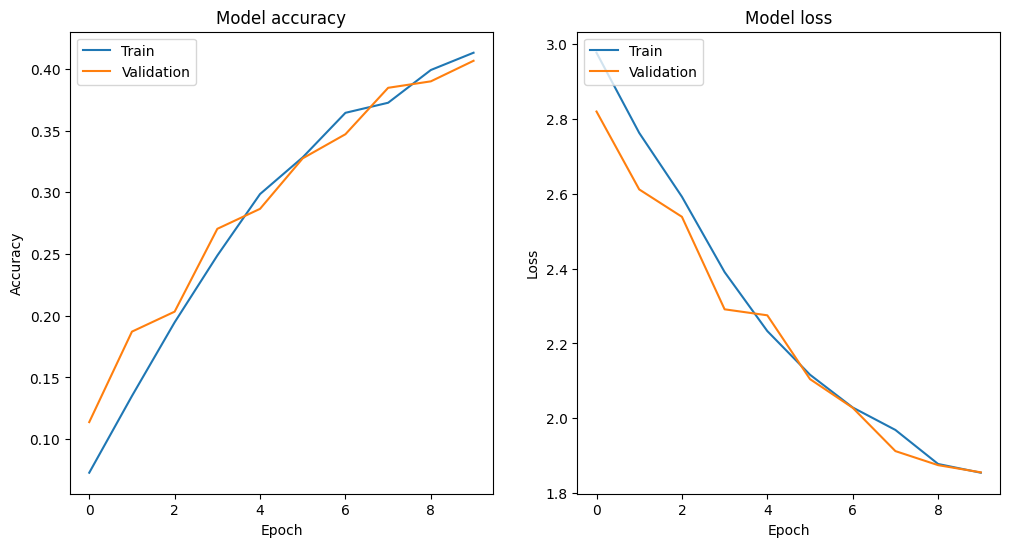

In [31]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Using Grid Search

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [97]:
train_dir = 'images_train_test_val/train'
validation_dir = 'images_train_test_val/validation'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.


In [98]:
def create_model(optimizer='adam', init_mode='uniform'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init_mode))
    model.add(Dropout(0.5))
    model.add(Dense(21, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [99]:
#create model
model = KerasClassifier(build_fn=create_model, verbose=0)

In [100]:
param_grid = {
    'optimizer': ['SGD', 'Adam'],
    'model__init_mode': ['uniform', 'he_normal'],
    'epochs': [10, 20],
    'batch_size': [10, 20]
}

In [101]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

In [105]:
# Using a smaller subset to avoid memory issues
X_train, y_train = next(train_generator)
for _ in range(5):  # Adjust the range to control the subset size
    X, y = next(train_generator)
    X_train = np.vstack((X_train, X))
    y_train = np.vstack((y_train, y))


In [106]:
grid_result = grid.fit(X_train, y_train)

c:\Users\User\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


c:\Users\User\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\User\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When us

In [109]:
best_params = grid_result.best_params_

# Retrieve best Keras Classfiier
best_model = create_model(optimizer=best_params['optimizer'], init_mode=best_params['model__init_mode'])

In [110]:
history = best_model.fit(
    train_generator,
    epochs=grid_result.best_params_['epochs'],
    validation_data=validation_generator,
    batch_size=grid_result.best_params_['batch_size']
)

Epoch 1/20


c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


230/230 ━━━━━━━━━━━━━━━━━━━━ 141s 601ms/step - accuracy: 0.0612 - loss: 3.0497 - val_accuracy: 0.0805 - val_loss: 3.0018
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 130s 559ms/step - accuracy: 0.0695 - loss: 3.0057 - val_accuracy: 0.0995 - val_loss: 2.9355
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 129s 555ms/step - accuracy: 0.0871 - loss: 2.9606 - val_accuracy: 0.0957 - val_loss: 2.9454
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 128s 550ms/step - accuracy: 0.1104 - loss: 2.9228 - val_accuracy: 0.1305 - val_loss: 2.8470
Epoch 5/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 129s 552ms/step - accuracy: 0.1161 - loss: 2.8815 - val_accuracy: 0.1652 - val_loss: 2.7637
Epoch 6/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 129s 555ms/step - accuracy: 0.1326 - loss: 2.8301 - val_accuracy: 0.1419 - val_loss: 2.7752
Epoch 7/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 130s 558ms/step - accuracy: 0.1427 - loss: 2.7828 - val_accuracy: 0.2143 - val_loss: 2.6254
Epoch 8/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 130s 555ms/step - accuracy: 0.1750 - loss: 2.70

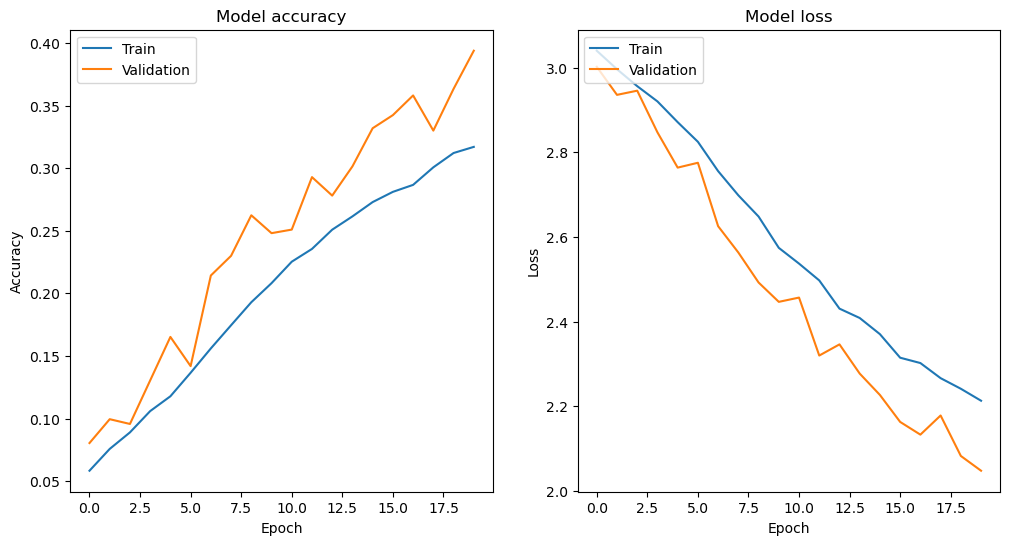

In [111]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [112]:
# Summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Best: 0.09895833333333333 using {'batch_size': 20, 'epochs': 20, 'model__init_mode': 'uniform', 'optimizer': 'SGD'}
0.046875 (0.01275775907699572) with: {'batch_size': 10, 'epochs': 10, 'model__init_mode': 'uniform', 'optimizer': 'SGD'}
0.052083333333333336 (0.01948779888944761) with: {'batch_size': 10, 'epochs': 10, 'model__init_mode': 'uniform', 'optimizer': 'Adam'}
0.046875 (0.02209708691207961) with: {'batch_size': 10, 'epochs': 10, 'model__init_mode': 'he_normal', 'optimizer': 'SGD'}
0.06770833333333333 (0.01948779888944761) with: {'batch_size': 10, 'epochs': 10, 'model__init_mode': 'he_normal', 'optimizer': 'Adam'}
0.052083333333333336 (0.02655739329996242) with: {'batch_size': 10, 'epochs': 20, 'model__init_mode': 'uniform', 'optimizer': 'SGD'}
0.052083333333333336 (0.00736569563735987) with: {'batch_size': 10, 'epochs': 20, 'model__init_mode': 'uniform', 'optimizer': 'Adam'}
0.015625 (0.02209708691207961) with: {'batch_size': 10, 'epochs': 20, 'model__init_mode': 'he_normal', '

Randomized Search

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [61]:
train_dir = 'images_train_test_val/train'
validation_dir = 'images_train_test_val/validation'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.


In [62]:
def create_model(num_filters=32, kernel_size=3, pool_size=2, dropout_rate=0.25, input_shape=(224, 224, 3), num_classes=21):
    model = Sequential()
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [63]:
model = KerasClassifier(model=create_model, verbose=0)


In [64]:
param_grid = {
    'model__num_filters': [32, 64, 128],
    'model__kernel_size': [3, 5],
    'model__pool_size': [2, 3],
    'model__dropout_rate': [0.25, 0.5],
    'epochs': [10, 20],
    'batch_size': [32, 64]
}

In [66]:
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, verbose=2)
random_search_result = random_search.fit(train_generator, validation_data=validation_generator)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.25, model__kernel_size=3, model__num_filters=128, model__pool_size=2; total time= 1.2min
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.25, model__kernel_size=3, model__num_filters=128, model__pool_size=2; total time= 1.2min
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.25, model__kernel_size=3, model__num_filters=128, model__pool_size=2; total time= 1.2min
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.25, model__kernel_size=3, model__num_filters=32, model__pool_size=2; total time=13.5min
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.25, model__kernel_size=3, model__num_filters=32, model__pool_size=2; total time= 1.2min
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.25, model__kernel_size=3, model__num_filters=32, model__pool_size=2; total time= 1.4min
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.5, model_

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 886, in _fit_and_score
    estimator.fit(X_train, **fit_params)
TypeError: KerasClassifier.fit() missing 1 required positional argument: 'y'


In [ ]:
# Get the best parameters and results
best_params = random_search_result.best_params_
best_score = random_search_result.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

In [ ]:
# Using the best model for evaluation
best_model = random_search_result.best_estimator_.model
train_loss, train_acc = best_model.evaluate(train_generator)
val_loss, val_acc = best_model.evaluate(validation_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}')